# Age Estimation and Gender Classification

In this project, you will train CNN models to estimate a person's age and predict their gender based on face images.

**Your Tasks**

You are supposed to train two CNN models.
- Model A: Train a CNN model from scratch, following a few restrictions. Save this model as `age_gender_A.keras`
- Model B: Fine-tune a pre-trained model to perform the same task. Save this model as `age_gender_B.keras`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During the assessment phase, your code will be tested on unseen test data.

**Performance Metric**

The evaluation of your models on the test set will be based on the following metrics:
- age estimation: - Mean Absolute Error (MAE)
- gender prediction: accuracy

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Visualize a few photos
It's always beneficial to thoroughly understand your data before beginning the training process. To get a first-hand impression of the dataset, please display a minimum of 20 images from the `train_val/` folder, along with their corresponding age and gender labels. This will help you gain initial insights into the dataset.

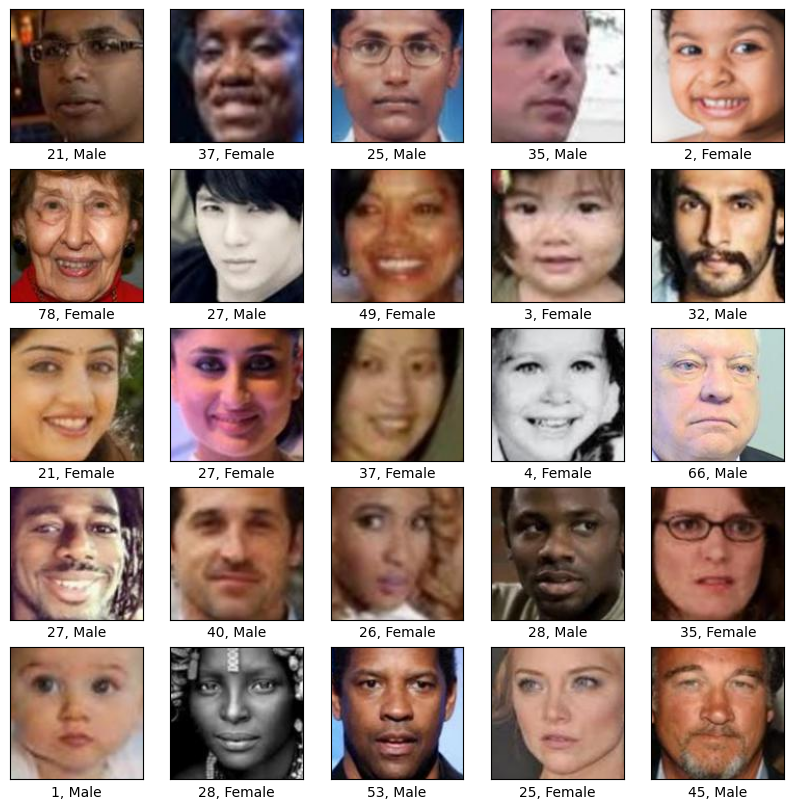

In [58]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread


folder_train_val = '/content/drive/MyDrive/Bath/Deep Learning/train_val/'
images = [f for f in os.listdir(folder_train_val)] #listdir() function from os gives access to the folder

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    filename = folder_train_val + images[i]
    image = imread(filename)
    plt.imshow(image)
    gender = images[i].split('_', 2)[1]
    if gender == '0':
        gender = 'Male'
    else:
        gender = 'Female'
    plt.xlabel(images[i].split('_', 1)[0] + ', ' + gender)
    plt.xticks([])
    plt.yticks([])
plt.show()



## Step 1: Data Pre-Processing
In this step, you will perform necessary pre-processing tasks before feeding the data into a CNN. The pre-processing includes:

1. Splitting the data into training and validation sets.
2. Loading image data, gender labels and age values, and rescaling pixel values (originally integers between 0 and 255) to the range [0, 1].
3. Data augmentation


Please note:

- Do not rescale the age values to the range [0,1], as the original values are used during the testing stage. Rescaling them would significantly impact testing performance.



In [59]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import cv2


folder_train_val = '/content/drive/MyDrive/Bath/Deep Learning/train_val'
all_image_files = [file for file in os.listdir(folder_train_val) if file.lower().endswith(('.jpg'))]

# Shuffle the dataset to ensure random distribution
random.seed(0)  # Ensure reproducibility
random.shuffle(all_image_files)

# Calculate the number of images for each set
n_train_val = len(all_image_files)
train_end = int(n_train_val * 0.8)

# Split the dataset
train_image_files = all_image_files[:train_end]
val_image_files = all_image_files[train_end:]
print(f"Number of images for training: {len(train_image_files)}")
print(f"Number of images for validation: {len(val_image_files)}")

def load_imgs_lables(dataset_path,filenames):
  print('load all image data, age and gender labels...')
  images = []
  age_labels = []
  gender_labels = []
  for current_file_name in filenames:
    img = cv2.imread(os.path.join(dataset_path, current_file_name)) #BGR
    img = img / 255.0  # Normalize pixel values so now between 0 and 1
    labels = current_file_name.split('_')
    age_label = int(labels[0])
    gender_label = int(labels[1])
    age_labels.append(age_label)
    gender_labels.append(gender_label)
    images.append(img)

  # Convert to NumPy arrays
  images = np.array(images)
  age_labels = np.array(age_labels)
  gender_labels = np.array(gender_labels)
  return images, age_labels, gender_labels

# load data from the training set
train_images, train_age, train_gender = load_imgs_lables(folder_train_val,train_image_files)

# load data from the validation set
val_images, val_age, val_gender = load_imgs_lables(folder_train_val,val_image_files)

# Data augmentation

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomShear(0.1)
])

Number of images for training: 4000
Number of images for validation: 1000
load all image data, age and gender labels...
load all image data, age and gender labels...


## STEP2A: Build your own CNN network
In this step, you will define your own CNN model for identifying gender and predicting age. Although there are two tasks, you only need to build one CNN model with two outputs. You may refer to online resources for solutions.

Here are the key requirements and restrictions for your network:
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2. Although it is technically correct to treat gender classification as a multi-class problem with 2 classes, i.e., 2 units in the last layer, the test code only supports a 1-unit last-layer configuration for the gender branch.
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	Incorporate techniques to prevent overfitting as appropriate.

At the end of your implementation, use `modelA.summary()` to display the model architecture and use `plot_model()` to visualize the architecture.

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 128, 128,  │          0 │ input_layer_30[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_133 (Conv2D) │ (None, 126, 126,  │        896 │ sequential_7[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 126, 126,  │        128 │ conv2d_133[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_179      │ (None, 126, 126,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 126, 126,  │          0 │ activation_179[0… │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_133   │ (None, 63, 63,    │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_134 (Conv2D) │ (None, 61, 61,    │      9,248 │ max_pooling2d_13… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        128 │ conv2d_134[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_180      │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 61, 61,    │          0 │ activation_180[0… │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_134   │ (None, 30, 30,    │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_135 (Conv2D) │ (None, 28, 28,    │     18,496 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_135[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_181      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_135   │ (None, 14, 14,    │          0 │ activation_181[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_136 (Conv2D) │ (None, 12, 12,    │     73,856 │ max_pooling2d_13

 Total params: 1,018,466 (3.89 MB)

 Trainable params: 1,015,906 (3.88 MB)

 Non-trainable params: 2,560 (10.00 KB)

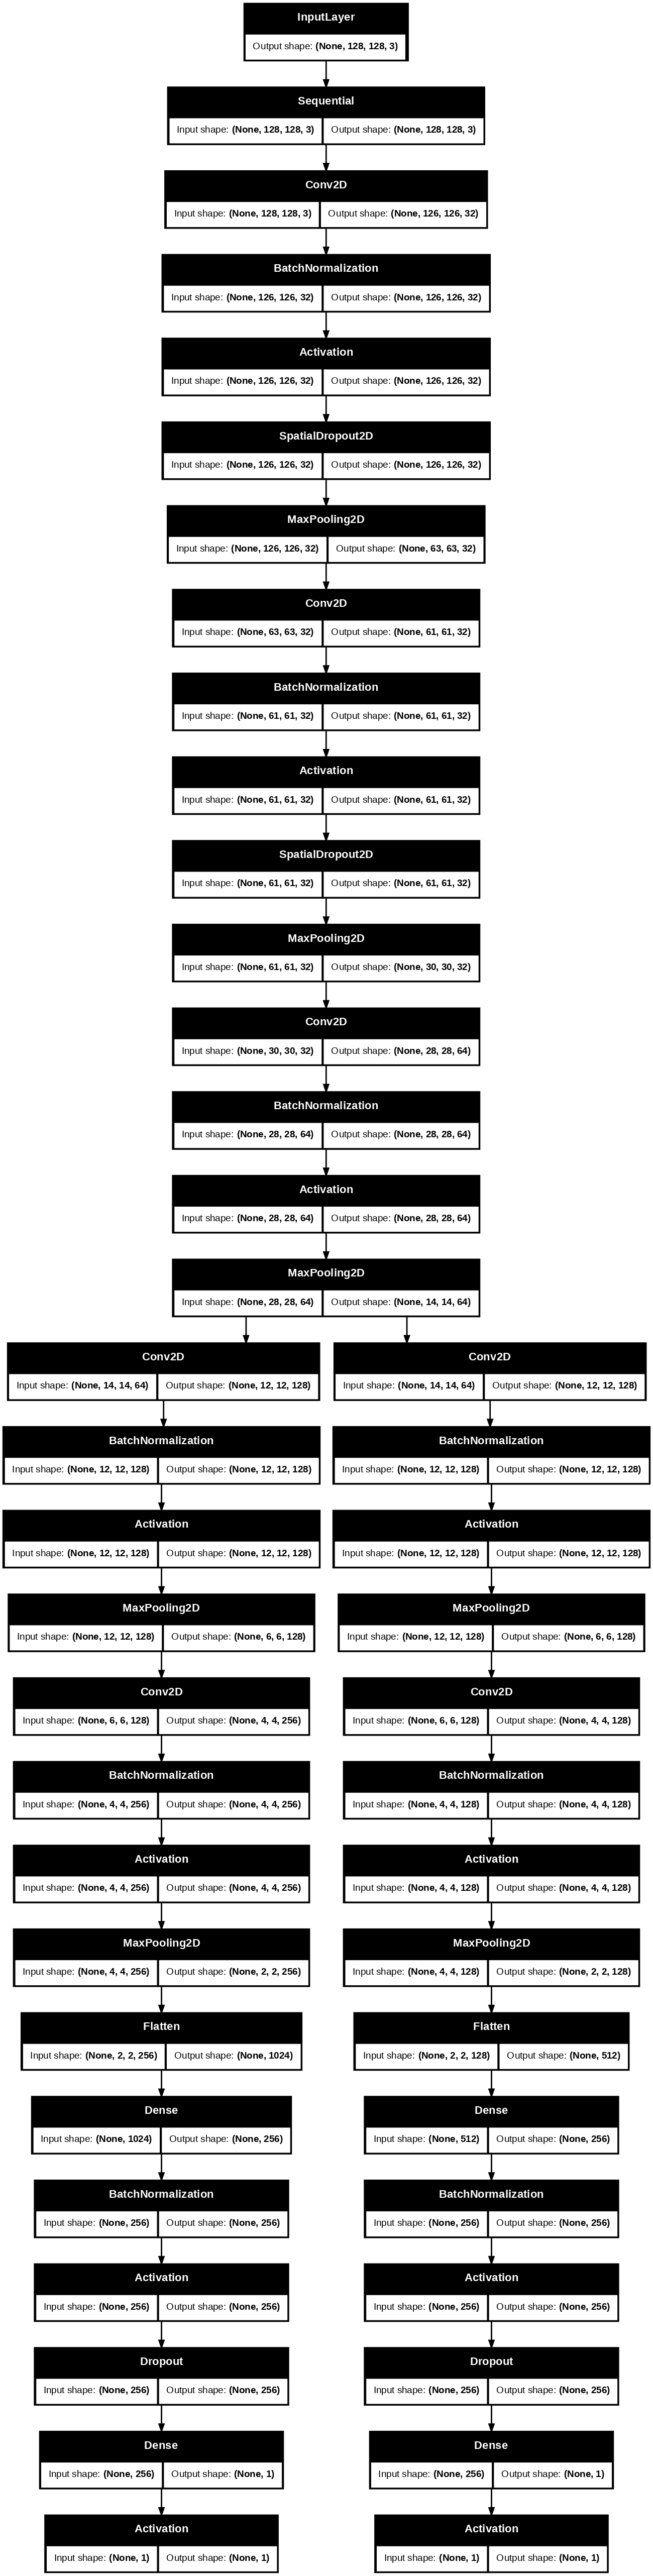

In [60]:
from tensorflow.keras.models import Sequential #sequential only works for one output.
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, Input, SpatialDropout2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import glorot_normal, he_normal, he_uniform

inputs = Input(shape=(128, 128, 3))
w = data_augmentation (inputs)

w = Conv2D(32, (3, 3),kernel_initializer='he_uniform')(w)
w = BatchNormalization(axis=-1)(w)
w = Activation("relu")(w)
w = SpatialDropout2D(0.25)(w)
w = MaxPooling2D(pool_size=(2, 2))(w)

w = Conv2D(32, (3, 3),kernel_initializer='he_uniform')(w)
w = BatchNormalization(axis=-1)(w)
w = Activation("relu")(w)
w = SpatialDropout2D(0.101)(w)
w = MaxPooling2D(pool_size=(2, 2))(w)

w = Conv2D(64, (3, 3),kernel_initializer='he_uniform')(w)
w = BatchNormalization(axis=-1)(w)
w = Activation("relu")(w)
w = MaxPooling2D(pool_size=(2, 2))(w)


x = Conv2D(128, (3, 3))(w)
x = BatchNormalization(axis=-1)(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(256, (3, 3))(x)
x = BatchNormalization(axis=-1)(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(256, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.4)(x)
x = Dense(1, kernel_initializer='glorot_normal')(x)
x = Activation("sigmoid", name="gender_output")(x)



y = Conv2D(128, (3, 3))(w)
y = BatchNormalization(axis=-1)(y)
y = Activation("relu")(y)
y = MaxPooling2D(pool_size=(2, 2))(y)

y = Conv2D(128, (3, 3))(y)
y = BatchNormalization(axis=-1)(y)
y = Activation("relu")(y)
y = MaxPooling2D(pool_size=(2, 2))(y)

y = Flatten()(y)

y = Dense(256, kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation("relu")(y)
y = Dropout(0.21)(y)
y = Dense(1)(y)
y = Activation("linear", name="age_output")(y)

modelA = Model(inputs = inputs,
               outputs = [x,y])

modelA.summary()
plot_model(modelA, show_shapes=True,dpi=100)

## STEP3A: Compile and train your model
Compile and train your model here.
Save your model by `modelA.save(your_model_folder+"age_gender_A.keras")` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()`** to save the entire model (including a model's architecture, weights, and training configuration) as a `.keras` zip archive. Don't save it with `save_weights()`.


In [61]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import keras

opt = keras.optimizers.Adam(learning_rate=0.0013)


modelA.compile(loss={'age_output': 'mse',
                    'gender_output': 'binary_crossentropy'},
              optimizer=opt,
              metrics={'age_output':'mae', 'gender_output':'accuracy'})

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=7, min_lr=1e-5, verbose=1)


epochs = 170
batch_size = 32

checkpoint_path = "best.weights.h5"
checkpoint = ModelCheckpoint(filepath = checkpoint_path, monitor = 'val_loss', save_best_only = True, save_weights_only = True, mode = 'min', verbose = 1)

history = modelA.fit(train_images, {'age_output': train_age, 'gender_output': train_gender}, validation_data=(val_images,{'age_output':val_age,'gender_output':val_gender}), callbacks=[reduce_lr, checkpoint], epochs=epochs, batch_size=batch_size)

if os.path.exists(checkpoint_path):
    modelA.load_weights(checkpoint_path)
else:
    print("Best weights not found. Latest weights being used.")

model_folder = '/content/drive/MyDrive/Colab Notebooks/models/'
modelA.save(model_folder+'age_gender_A.keras')

Epoch 1/170
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - age_output_loss: 1225.8896 - age_output_mae: 29.2344 - gender_output_accuracy: 0.5649 - gender_output_loss: 0.8074 - loss: 1226.6969
Epoch 1: val_loss improved from inf to 913.62433, saving model to best.weights.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - age_output_loss: 1221.7974 - age_output_mae: 29.1701 - gender_output_accuracy: 0.5653 - gender_output_loss: 0.8064 - loss: 1222.6038 - val_age_output_loss: 919.8063 - val_age_output_mae: 24.7465 - val_gender_output_accuracy: 0.6040 - val_gender_output_loss: 0.6521 - val_loss: 913.6243 - learning_rate: 0.0013
Epoch 2/170
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - age_output_loss: 424.2686 - age_output_mae: 15.6247 - gender_output_accuracy: 0.6175 - gender_output_loss: 0.6721 - loss: 424.9407
Epoch 2: val_loss improved from 913.62433 to 410.52414, saving model to best.weights.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - age_output_loss: 423.5916 - age_output_mae: 15.6105 - g

## STEP4A: Draw the learning curves
Draw four learning curve figures for model A as follows.
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

Text(0.5, 0, 'epoch')

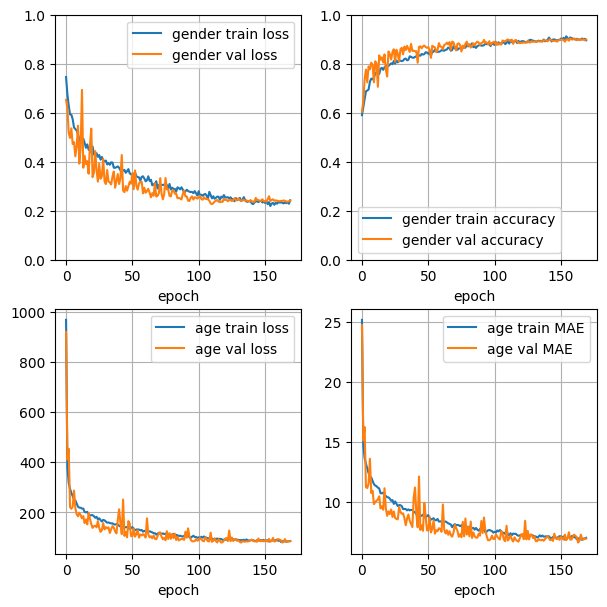

In [62]:
import matplotlib.pyplot as plt
#print(history.history.keys())

fig = plt.figure(figsize=(7,7))

fig.add_subplot(2,2,1)
plt.plot(history.history['gender_output_loss'], label='gender train loss')
plt.plot(history.history['val_gender_output_loss'], label='gender val loss')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')

fig.add_subplot(2,2,2)
plt.plot(history.history['gender_output_accuracy'], label='gender train accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label='gender val accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')

fig.add_subplot(2,2,3)
plt.plot(history.history['age_output_loss'], label='age train loss')
plt.plot(history.history['val_age_output_loss'], label='age val loss')
plt.legend()
plt.grid(True)
plt.xlabel('epoch')

fig.add_subplot(2,2,4)
plt.plot(history.history['age_output_mae'], label='age train MAE')
plt.plot(history.history['val_age_output_mae'], label='age val MAE')
plt.legend()
plt.grid(True)
plt.xlabel('epoch')

## STEP2B: Build a CNN network based on a pre-trained model
Choose an existing CNN architecture pre-trained on ImageNet and fine-tune it on this dataset.

As with Model A, **do not resize the input image size**.
Ensure that the output layer for **the gender branch has only 1 unit**.

At the end of the cell, use `modelB.summary()` to display the model architecture and use `plot_model()` to visualize the architecture.


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_51      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_14       │ (None, 128, 128,  │          0 │ input_layer_51[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 128, 128,  │          0 │ sequential_14[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_8         │ (None, 128, 128,  │          0 │ lambda_8[0][0]    │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_24         │ (None, 128, 128)  │          0 │ rescaling_8[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_25         │ (None, 128, 128)  │          0 │ rescaling_8[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_26         │ (None, 128, 128)  │          0 │ rescaling_8[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_8 (Stack)     │ (None, 128, 128,  │          0 │ get_item_24[0][0… │
│                     │ 3)                │            │ get_item_25[0][0… │
│                     │                   │            │ get_item_26[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 128, 128,  │          0 │ stack_8[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 4, 4, 512) │ 14,714,688 │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_88          │ (None, 512)       │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_91          │ (None, 512)       │          0 │ dropout_88[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_128 (Dense)   │ (None, 1024)      │    525,312 │ dropout_88[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_131 (Dense)   │ (None, 512)       │    262,656 │ dropout_91[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_128[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_131[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 16,168,770 (61.68 MB)

 Trainable params: 1,449,474 (5.53 MB)

 Non-trainable params: 14,719,296 (56.15 MB)

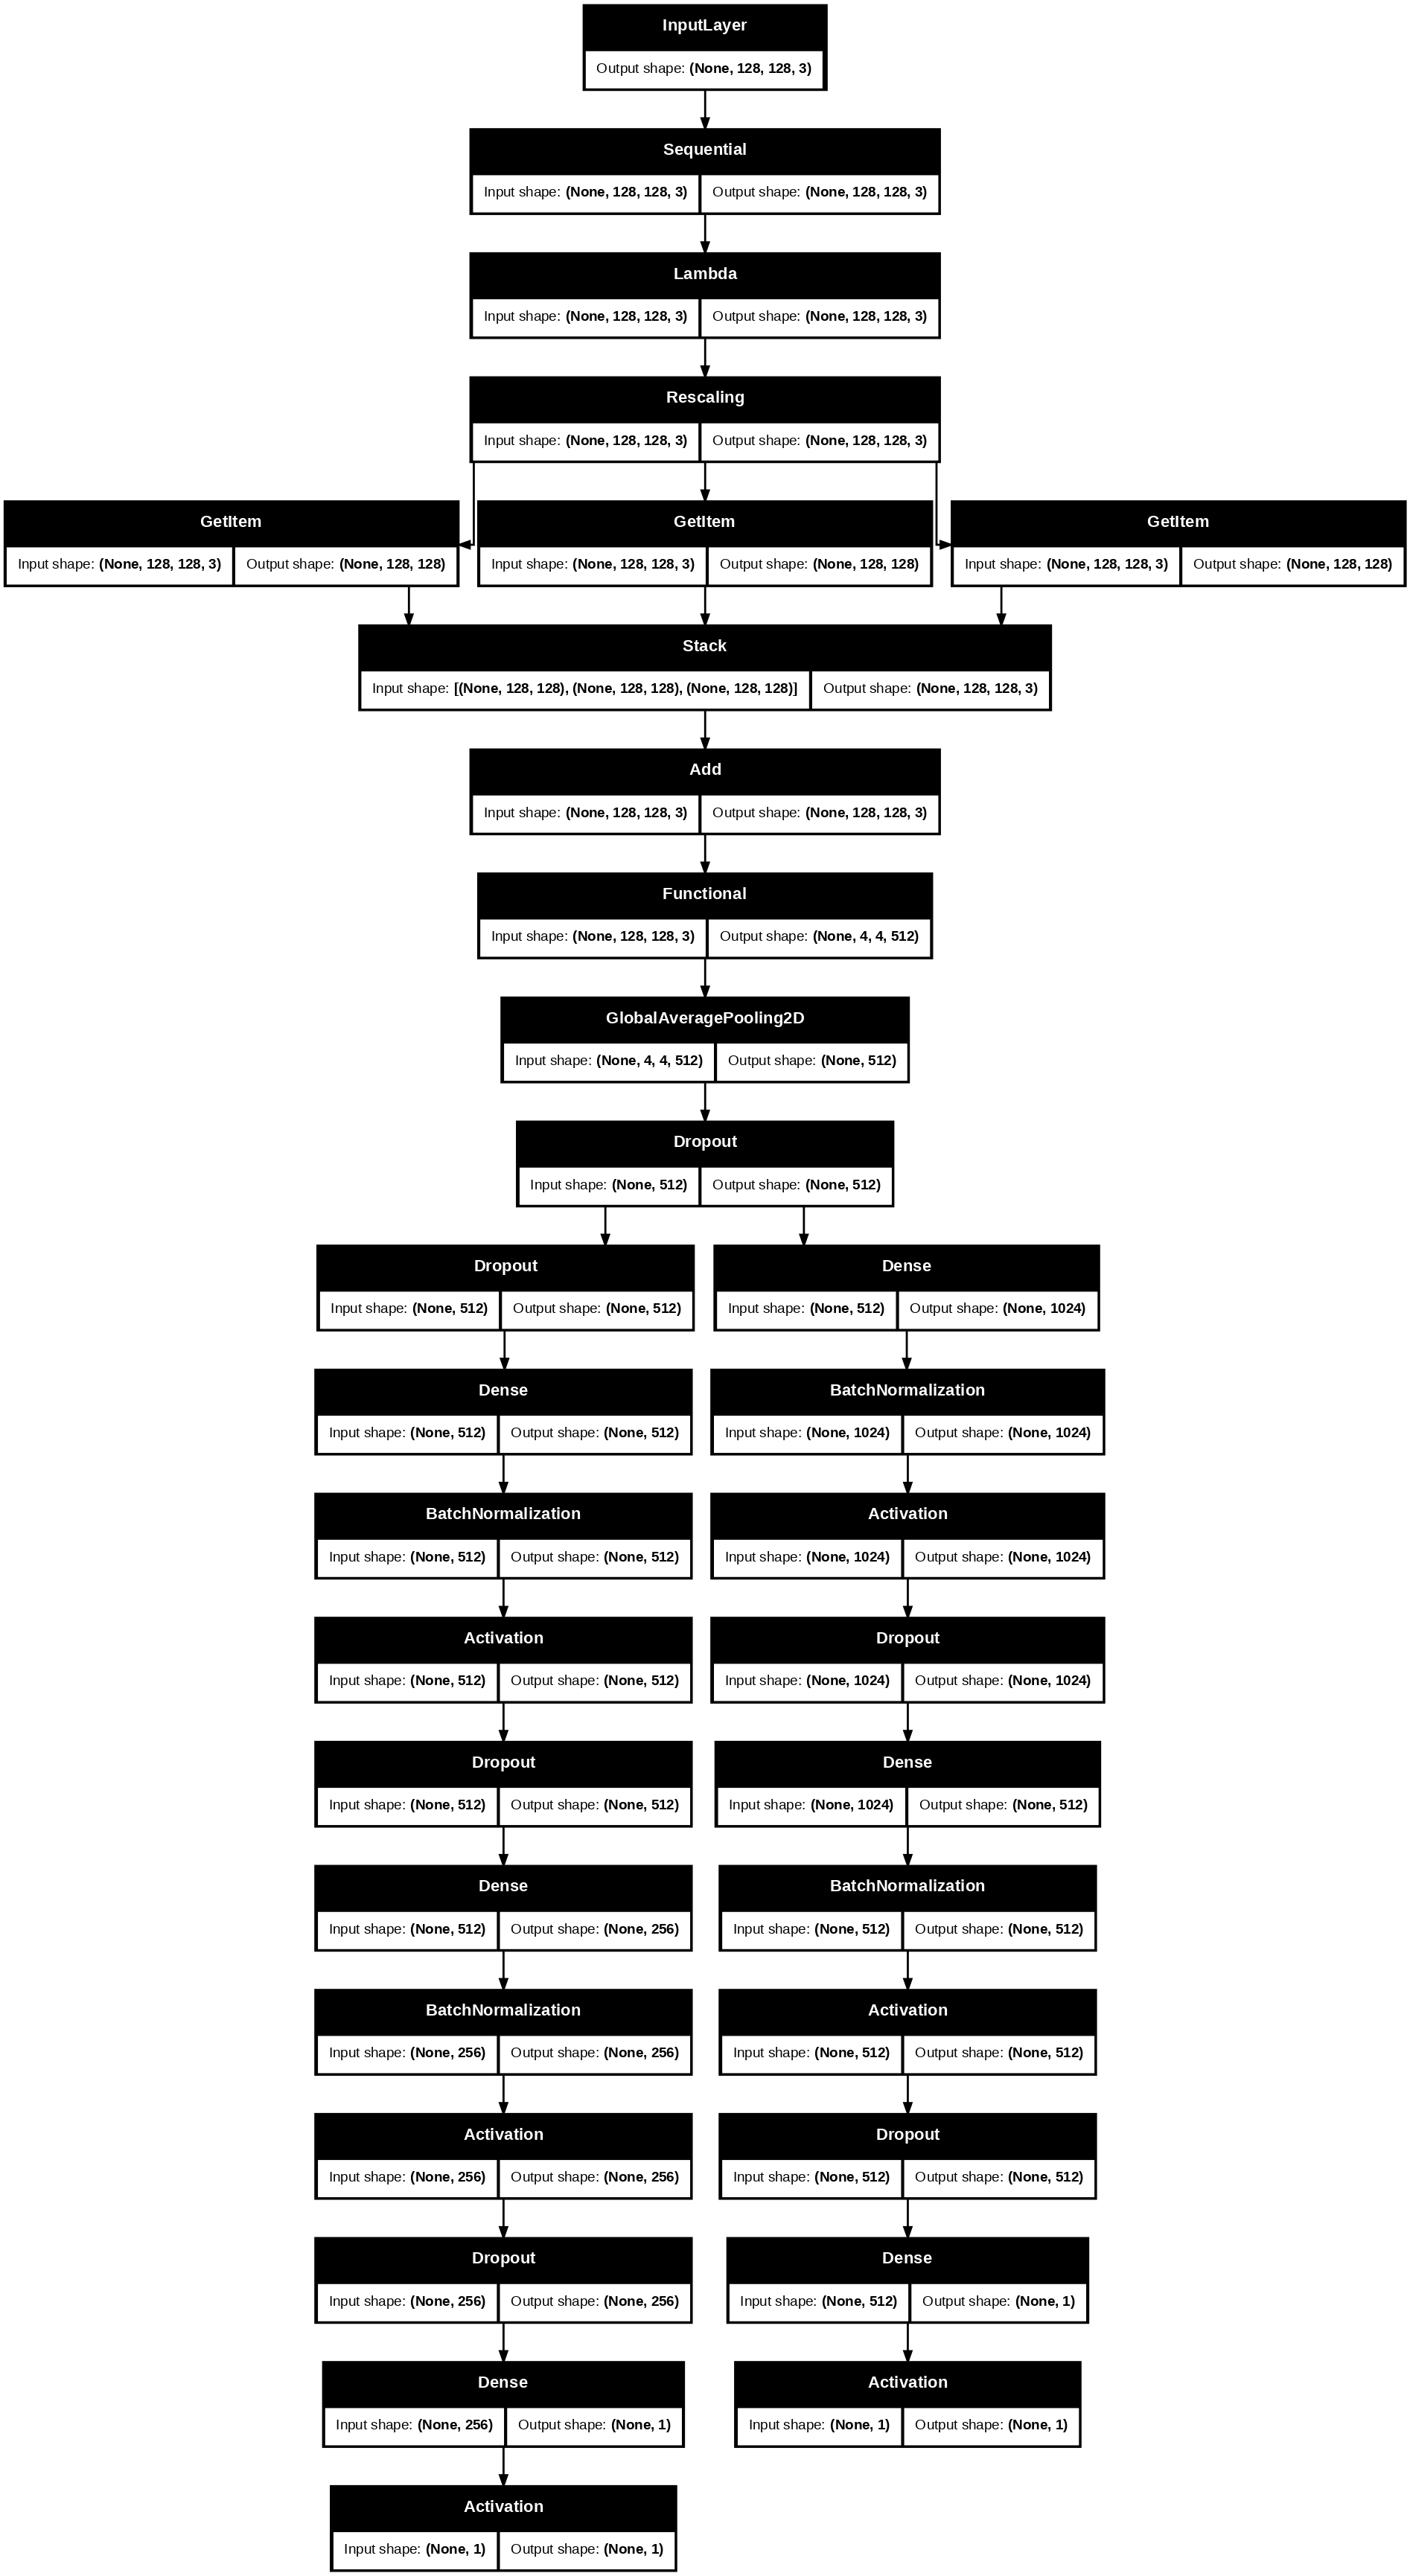

In [77]:
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetV2B2, VGG16 #use training = False if batch norm is used in base model.
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, Input, SpatialDropout2D, GlobalAveragePooling2D, Lambda, LeakyReLU, PReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import glorot_normal, he_normal, he_uniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.vgg16 import preprocess_input



data_augmentation2 = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
])

conv_base = VGG16(weights = 'imagenet',
                  include_top = False, # do not include the FC layers
                  input_shape = (128, 128, 3))


conv_base.trainable = False

#conv_base.summary()

rescale = tf.keras.layers.Rescaling(255.0) #w goes from [0,1] to [0,255]

inputs = Input(shape=(128, 128, 3))
w = data_augmentation2 (inputs)
w = Lambda(lambda img: img[..., ::-1])(w) #batchxhxwx3 #flips last dimension of image i.e. rgb bit. bgr --> rgb #Lambda creates a keras layer: w = w[...,::-1] works normally but not here since need a keras layer
w = rescale(w)
w = preprocess_input(w)
w = conv_base(w)
w = GlobalAveragePooling2D()(w) #for each sample in the batch, averages over height and width to give one number per rgb channel.
w = Dropout(0.2)(w)

x = Dense(1024, kernel_initializer='he_uniform')(w)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.2)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.2)(x)

x = Dense(1,kernel_initializer='glorot_normal')(x)
x = Activation("sigmoid", name="gender_output")(x)

y = Dropout(0.1)(w)
y = Dense(512, kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation("relu")(y)
y = Dropout(0.5)(y)

y = Dense(256)(y)
y = BatchNormalization()(y)
y = Activation("relu")(y)
y = Dropout(0.5)(y)

y = Dense(1)(y)
y = Activation("linear", name="age_output")(y)

modelB = Model(inputs = inputs, outputs = [x,y])
modelB.summary()

from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True,dpi=100)

## STEP3B: Compile and train your model
Compile and train your model here.
Save your model to `age_gender_B.keras` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.**


In [78]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW, Adam, RMSprop
from tensorflow.keras.optimizers import SGD

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=4, verbose=1, min_lr=1e-7)
#early_stopping = EarlyStopping( monitor='val_loss', min_delta = 0.001, patience=10, restore_best_weights=True)

checkpoint_path_B = "bestB.weights.h5"
checkpoint = ModelCheckpoint(filepath = checkpoint_path_B, monitor = 'val_gender_output_accuracy', save_best_only = True, save_weights_only = True, mode = 'max', verbose = 1)

callbacks = [lr_scheduler, checkpoint]
lr1 = 0.001
batch_size = 32

modelB.compile(loss = {'age_output': 'mse',
                     'gender_output': 'binary_crossentropy'},
               loss_weights = {
                   'age_output': 1.0,
                   'gender_output': 10.0
               },
              optimizer = AdamW(learning_rate = lr1, weight_decay = 0.00001),
              metrics = {'age_output':'mae', 'gender_output':'accuracy'})

initial_epochs = 5
history = modelB.fit(train_images, {'age_output': train_age, 'gender_output': train_gender}, validation_data=(val_images,{'age_output':val_age,'gender_output':val_gender}), epochs=initial_epochs, batch_size=batch_size, callbacks = callbacks)

for layer in conv_base.layers[-8:]:
    layer.trainable = True

lr2 = 0.00002

modelB.compile(loss = {'age_output': 'mse',
                     'gender_output': 'binary_crossentropy'},
               loss_weights = {
                   'age_output': 1.0,
                   'gender_output': 10.0
               },
              optimizer = RMSprop(learning_rate = lr2, weight_decay = 0.00001),
              metrics = {'age_output':'mae', 'gender_output':'accuracy'})

fine_tune_epochs = 125
total_epochs =  initial_epochs + fine_tune_epochs
history_post = modelB.fit(train_images, {'age_output': train_age, 'gender_output': train_gender}, validation_data=(val_images,{'age_output':val_age,'gender_output':val_gender}), epochs=total_epochs, initial_epoch=history.epoch[-1], batch_size=batch_size, callbacks = callbacks)

if os.path.exists(checkpoint_path_B):
    modelB.load_weights(checkpoint_path_B)
else:
    print("Best weights not found. Latest weights being used.")

model_folder = '/content/drive/MyDrive/Colab Notebooks/models/'
modelB.save(model_folder+"age_gender_B.keras")

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - age_output_loss: 1299.2386 - age_output_mae: 30.7875 - gender_output_accuracy: 0.6857 - gender_output_loss: 0.6686 - loss: 1305.9242
Epoch 1: val_gender_output_accuracy improved from -inf to 0.70700, saving model to bestB.weights.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - age_output_loss: 1297.4701 - age_output_mae: 30.7620 - gender_output_accuracy: 0.6858 - gender_output_loss: 0.6682 - loss: 1304.1522 - val_age_output_loss: 997.2762 - val_age_output_mae: 27.8627 - val_gender_output_accuracy: 0.7070 - val_gender_output_loss: 0.8141 - val_loss: 1001.4549 - learning_rate: 0.0010
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - age_output_loss: 519.5889 - age_output_mae: 18.2602 - gender_output_accuracy: 0.7331 - gender_output_loss: 0.5396 - loss: 524.9849
Epoch 2: val_gender_output_accuracy improved from 0.70700 to 0.81300, saving model to bestB.weights.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - age_output_loss: 519.0216 

## STEP4B: Draw the learning curves
Draw four learning curve figures for model B as follows.
1. The loss of the gender classification over the training and validation set
2. The accuracy of the gender classification over the training and validation set
3. The loss of the age estimation over the training and validation set
4. The MAE of the age estimation over the training and validation set

Text(0.5, 0, 'epoch')

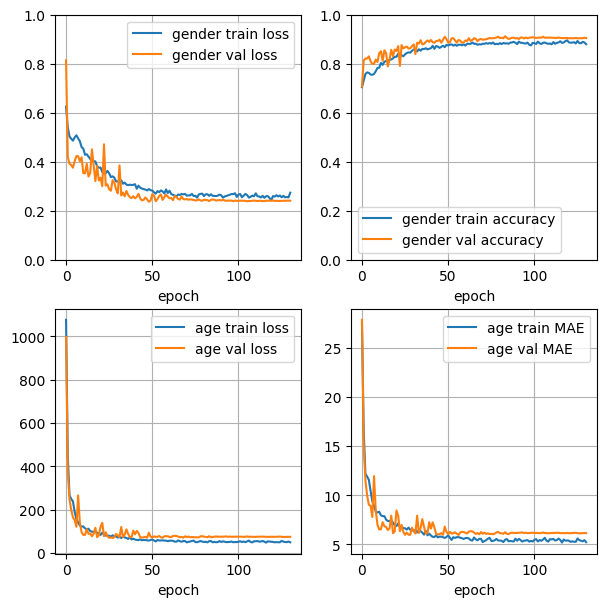

In [79]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,7))
gender_acc = history.history['gender_output_accuracy'] + history_post.history['gender_output_accuracy']
val_gender_acc = history.history['val_gender_output_accuracy'] + history_post.history['val_gender_output_accuracy']

gender_loss = history.history['gender_output_loss'] + history_post.history['gender_output_loss']
val_gender_loss = history.history['val_gender_output_loss'] + history_post.history['val_gender_output_loss']

age_loss = history.history['age_output_loss'] + history_post.history['age_output_loss']
val_age_loss = history.history['val_age_output_loss'] + history_post.history['val_age_output_loss']

age_mae = history.history['age_output_mae'] + history_post.history['age_output_mae']
val_age_mae = history.history['val_age_output_mae'] + history_post.history['val_age_output_mae']


fig.add_subplot(2,2,1)
plt.plot(gender_loss, label='gender train loss')
plt.plot(val_gender_loss, label='gender val loss')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')

fig.add_subplot(2,2,2)
plt.plot(gender_acc, label='gender train accuracy')
plt.plot(val_gender_acc, label='gender val accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')

fig.add_subplot(2,2,3)
plt.plot(age_loss, label='age train loss')
plt.plot(val_age_loss, label='age val loss')
plt.legend()
plt.grid(True)
plt.xlabel('epoch')

fig.add_subplot(2,2,4)
plt.plot(age_mae, label='age train MAE')
plt.plot(val_age_mae, label='age val MAE')
plt.legend()
plt.grid(True)
plt.xlabel('epoch')

## STEP5: Evaluate the model on the test set
I will load your two models for testing. The test set will not be available before your submission.

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [66]:
#
# Don't add code in this cell when submitting this file
#